In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad_vec
from numba import njit

Analytical model for quantitative
prediction of material contrasts in
scattering-type near-field optical
microscopy

$$

\epsilon(\omega) =~ 1 + \frac{A_p}{\omega^2_0 - \omega^2 - i\gamma\omega} , \text{    }

\beta(\omega) = \frac{\epsilon(\omega) - 1}{\epsilon(\omega) +1}
\\
==============================
\\
r_p(\omega) = \frac{n_2(\omega) \cos{\theta_i} - n_1 \cos{(\theta_t(\omega))}}{n_2(\omega) \cos{\theta_i} + n_1 \cos{(\theta_t(\omega))}}, \\ \text{   } \\
\sin{(\theta_t(\omega))} = \frac{n_1}{n_2(\omega)}\sin{\theta_i}, 
\text{   } n_2(\omega) = \sqrt{\epsilon(\omega)} , \text{  } n_1 = n_{ar} = 1
\\
==============================
\\
\alpha_{eff}(\omega, t) = \frac{1}{2}\frac{\beta(\omega) f_0(t)}{1 - \beta(\omega) f_1(t)} + 1,\\ 
\text{ }\\
f_{0, 1}(t) = (g - \frac{\rho + 2H(t) + W_{0,1}}{2L})\frac{\ln{\frac{4L}{\rho + 4H(t) + 2W_{0,1}}}}{\ln{\frac{4L}{\rho}}}, 
\\ \text{ } \\ 
H(t) = H_0 + A(1 - \cos(\Omega t))

\\ \text{ } \\ 

W_0 = 1.31\rho, \text{ } W_1 = 0.5\rho, \text{ } g = 0.7e^{0.06i}

\\
==============================
\\
S_n(\omega) = \ \int_{0}^{\frac{2\pi}{\Omega}} (1 + r_p(\omega))^2 \alpha_{eff}(\omega, t) e^{-i n \Omega t} \,dt \

$$
 A = 20nm, $\rho $ = 20nm, L = 300nm

In [2]:
@njit
def calculate_epsilon(omega,  A_parameter, omega_0, gamma):
    denominator = (omega_0**2-omega**2-1.0j*omega*gamma)
    return 1 + A_parameter/denominator

@njit
def calculate_beta(epsilon):
    return (epsilon-1)/(epsilon+1)

@njit
def calculate_rp(epsilon_mat, theta_i):
    epsilon_air = 1.0 
    
    n1 = np.sqrt(epsilon_air)   
    n2 = np.sqrt(epsilon_mat)      
    # snell law
    sin_theta_t = (n1 / n2) * np.sin(theta_i)
    cos_theta_t = np.sqrt(1 - sin_theta_t**2)  # non absorvent medium

    rp = (n2 * np.cos(theta_i) - n1 * cos_theta_t) / (n2 * np.cos(theta_i) + n1 * cos_theta_t)
    return rp

@njit
def calculate_f_parameter(g, radius, H, W, L):
    f = (g - (radius +2*H + W)/(2*L))*(np.log(4*L/(radius + 4*H +2*W)))/np.log(4*L/radius)
    return f

@njit
def calculate_H_t(t, A, Omega, H0):
    return H0 + A*(1 - np.cos(Omega*t))

@njit
def calculate_alpha_eff(beta, f0, f1):
    return 1 + 0.5 * (beta*f0)/(1 - beta*f1)


In [3]:
A_PARAMETER = 700**2 #cm⁻2
OMEGA0 = 700 #cm⁻¹
GAMMA = 20 #cm⁻¹
THETA_I = np.deg2rad(45)  # 45°

G = 0.7*(np.cos(0.06) + 1.0j*np.sin(0.06))

A = 18*1e-9 #m
RADIUS = 20*1e-9 #m
L = 300*1e-9 #m

W0 = 1.31*RADIUS
W1 = 0.5*RADIUS

Omega = 2*np.pi*(250*1e3) #rad/s
H0 = 0

@njit
def calculate_integrand(t, omega, n):
    epsilon = calculate_epsilon(omega, A_PARAMETER, OMEGA0, GAMMA)
    beta = calculate_beta(epsilon)
    rp = calculate_rp(epsilon, THETA_I)
    
    H = calculate_H_t(t, A, Omega, H0)
    f0 = calculate_f_parameter(G, RADIUS, H, W0, L)
    f1 = calculate_f_parameter(G, RADIUS, H, W1, L)

    alpha_eff = calculate_alpha_eff(beta, f0, f1)

    integrand = ((1+rp)**2)*(alpha_eff) * (np.exp(-1.0j * Omega * n * t))
    return integrand


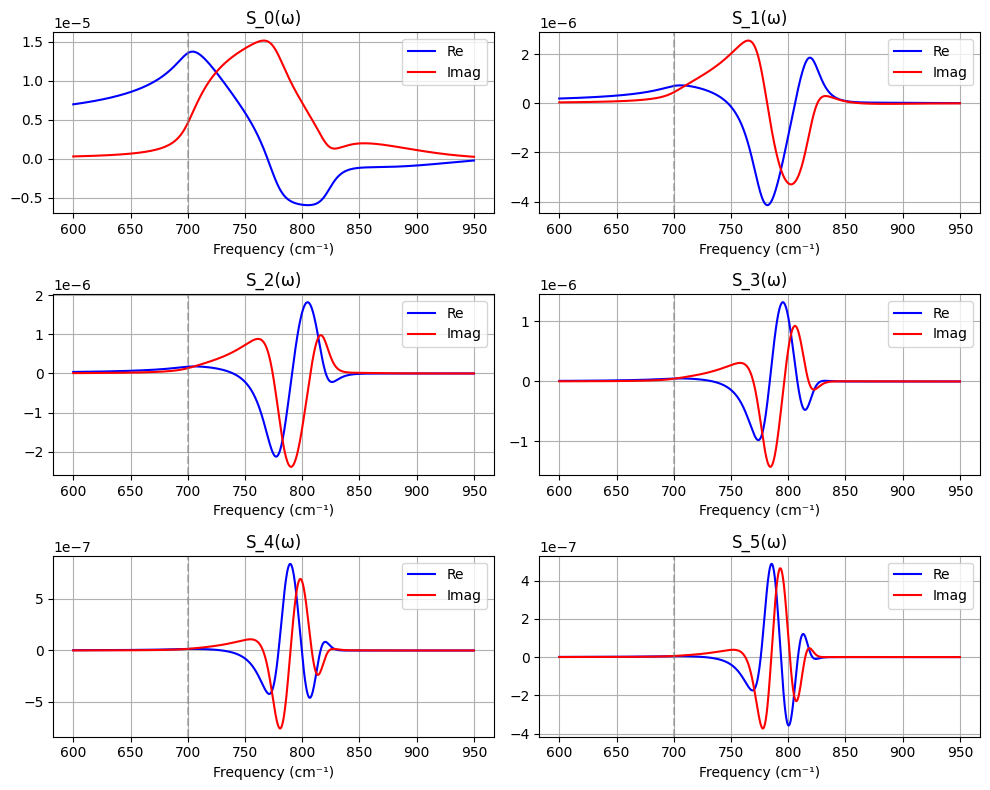

In [ ]:
omega_cm = np.linspace(600, 950, 1000)  # Faixa experimental em cm⁻¹

n_values = [0, 1, 2, 3, 4, 5]
integrated_values = np.ndarray(shape=[len(omega_cm), len(n_values)], dtype=np.complex128)

for i, omega in enumerate(omega_cm):
    for j, n_value in enumerate(n_values):
        result, error = quad_vec(lambda x: calculate_integrand(x, omega, n_value), 0, 2*np.pi/Omega)
        integrated_values[i, j] = result


fig, axs = plt.subplots(figsize = (10,8),nrows=int(len(n_values)/2), ncols=2)
axes = axs.flatten()
for i, n_value in enumerate(n_values):
    axes[i].plot(omega_cm, np.real(integrated_values[:, i]), label='Re', color='blue')
    axes[i].plot(omega_cm, np.imag(integrated_values[:, i]), label='Imag', color='red')
    axes[i].axvline(x=OMEGA0, color='gray', linestyle='--', alpha=0.5)
    axes[i].set_xlabel('Frequency (cm⁻¹)')
    axes[i].set_title(f'S_{n_value}(ω)')
    axes[i].legend()
    axes[i].grid(True)
plt.tight_layout()
plt.show()


In [5]:
# omega_cm = np.linspace(400, 1000, 500)  # Faixa experimental em cm⁻¹
# time_vector = np.linspace(0, 2*np.pi/Omega, 500)  # seconds

# integrand_omega_t = np.ndarray(shape=[len(omega_cm), len(time_vector)], dtype=np.complex128)

# for i in range(0, len(omega_cm)):
#     for j in range(0, len(time_vector)):
#         integrand_omega_t[i, j] = calculate_integrand(time_vector[j], omega_cm[i], n=1)

# plot_data = np.real(integrand_omega_t.T)  # Transpose for correct axis orientation

# fig, axs = plt.subplots(figsize = (10,6),nrows=2, ncols=1)

# img0 = axs[0].imshow(np.real(integrand_omega_t.T),
#                  aspect='auto',
#                  origin='lower',
#                  extent=[omega_cm.min(), omega_cm.max(),  # x-axis (omega)
#                          time_vector.min(), time_vector.max()],  # y-axis (time)
#                  cmap='viridis')

# # Add labels and colorbar
# # axs[0].set_colorbar(label='Magnitude of Integrand')
# axs[0].set_xlabel('Wavenumber (cm⁻¹)')
# axs[0].set_ylabel('Time')
# axs[0].set_title(r'Real Integrand $(1+r_p(\omega))^2*\alpha_{eff}(\omega, t)*e^{-i\Omega t}$')
# fig.colorbar(img0, ax=axs[0])

# img1 = axs[1].imshow(np.imag(integrand_omega_t.T),
#                  aspect='auto',
#                  origin='lower',
#                  extent=[omega_cm.min(), omega_cm.max(),  # x-axis (omega)
#                          time_vector.min(), time_vector.max()],  # y-axis (time)
#                  cmap='viridis')

# axs[1].set_xlabel('Wavenumber (cm⁻¹)')
# axs[1].set_ylabel('Time')
# axs[1].set_title(r'Imaginary Integrand $(1+r_p(\omega))^2*\alpha_{eff}(\omega, t)$')
# fig.colorbar(img1, ax=axs[1])
# plt.tight_layout()
# plt.show()